Goal : Preserving conversational history

Step 1: importing required packages

In [ ]:
! pip install  langgraph
! pip install langchain 
! pip install langchain_core_google_genai 
! pip install typing_extensions 
! pip install langchain_core


In [2]:
from langgraph.graph import START, END, StateGraph, add_messages , MessagesState
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import Literal, Annotated
from typing_extensions import TypedDict 
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage ,RemoveMessage
from _collections_abc import Sequence


c:\Users\star\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Step 2: add_message function

In [3]:
my_list = add_messages([HumanMessage("What is linkedin?"), 
                        AIMessage("Linkedin is professional platform for networking worldwide."),],
                       [HumanMessage("Could you please tell me about its founders?"),])

In [4]:
my_list

[HumanMessage(content='What is linkedin?', additional_kwargs={}, response_metadata={}, id='b506498f-082c-4226-93d7-6df685f88d1b'),
 AIMessage(content='Linkedin is professional platform for networking worldwide.', additional_kwargs={}, response_metadata={}, id='d3141aff-2dba-4cb2-8744-3d39c35aadcd', tool_calls=[], invalid_tool_calls=[]),
 HumanMessage(content='Could you please tell me about its founders?', additional_kwargs={}, response_metadata={}, id='eeec9e2e-cb47-4f61-9afd-2e245141385f')]

Step 3: Define State

In [5]:
class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

Step 4: Define node

In [6]:
chat = ChatGoogleGenerativeAI(model="gemini-flash-latest", temperature=0, seed  =365, max_tokens=100)


In [7]:
def ask_question(state: MessagesState) -> MessagesState:
    
    print(f"\n-------> ENTERING ask_question:")
    for i in state["messages"]:
        i.pretty_print()
    
    question = "What is your question?"
    print(question)
    
    return MessagesState(messages = [AIMessage(question), HumanMessage(input())])

In [8]:
def chatbot(state: MessagesState) -> MessagesState:
    
    print(f"\n-------> ENTERING chatbot:")
    for i in state["messages"]:
        i.pretty_print()
    
    response = chat.invoke(state["messages"])
    response.pretty_print()
    
    return MessagesState(messages = [response])

In [9]:
def ask_another_question(state: MessagesState) -> MessagesState:
    
    print(f"\n-------> ENTERING ask_another_question:")
    
    for i in state["messages"]:
        i.pretty_print()
    
    question = "Would you like to ask one more question (yes/no)?"
    print(question)
    
    return MessagesState(messages = [AIMessage(question), HumanMessage(input())])

In [10]:
def trim_messages(state: MessagesState) -> MessagesState:
    print(f"-------->entering trim_meeasges:")
    remove_message= [RemoveMessage(id = i. id)for i in state["messages"][:-5]]
    return MessagesState(messages=remove_message)

Step 5: Define routing function

In [11]:
def routing_function(state: MessagesState) -> Literal["trim_messages", "__end__"]:
    
    if state["messages"][-1].content == "yes":
        return "trim_messages"
    else:
        return "__end__"

Step 6: define graph

In [12]:
graph = StateGraph(MessagesState)

In [13]:
graph.add_node("ask_question", ask_question)
graph.add_node("chatbot", chatbot)
graph.add_node("ask_another_question", ask_another_question)
graph.add_node("trim_messages", trim_messages)

graph.add_edge(START, "ask_question")
graph.add_edge("ask_question", "chatbot")
graph.add_edge("chatbot", "ask_another_question")
graph.add_conditional_edges(source = "ask_another_question", 
                            path = routing_function)
graph.add_edge("trim_messages", "ask_question")

In [14]:
graph_compiled = graph.compile()

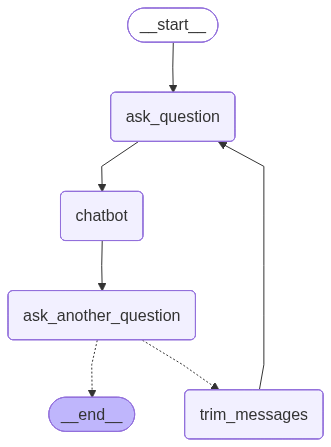

In [15]:
graph_compiled

Step 7: Test the graph

In [16]:
graph_compiled.invoke(MessagesState(messages = []))


-------> ENTERING ask_question:
What is your question?

-------> ENTERING chatbot:
================================== Ai Message ==================================

What is your question?
================================ Human Message =================================

who founded linkedin?
================================== Ai Message ==================================

LinkedIn was founded by **Reid Hoffman**, **Allen Blue**, **Konstant Constantine**, **Eric Ly**, and **Jean-Luc Vaillant**.

-------> ENTERING ask_another_question:
================================== Ai Message ==================================

What is your question?
================================ Human Message =================================

who founded linkedin?
================================== Ai Message ==================================

LinkedIn was founded by **Reid Hoffman**, **Allen Blue**, **Konstant Constantine**, **Eric Ly**, and **Jean-Luc Vaillant**.
Would you like to ask one more question (yes/

{'messages': [AIMessage(content='What is your question?', additional_kwargs={}, response_metadata={}, id='d4336002-abd1-41b4-95f5-142f10638d0b', tool_calls=[], invalid_tool_calls=[]),
  HumanMessage(content='where was he born', additional_kwargs={}, response_metadata={}, id='a1219bc6-4d0b-4bca-9ce5-f014f1ea5b41'),
  AIMessage(content='Since you asked "where was **he** born," and there are five founders, I will assume you are asking about the most prominent founder, **Reid Hoffman**.\n\n**Reid Hoffman** was born in **Palo Alto, California.**', additional_kwargs={}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash-preview-09-2025', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019c1f4a-7d78-7032-98a6-16ba0b33d214-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 115, 'output_tokens': 50, 'total_tokens': 165, 'input_token_details': {'cache_read': 0}}),
  AIMessage(content='Would you like to ask one more question (ye